# A short guide on how to use mixed random forests

## Introduction

This document gives a short tutorial on how to use mixed random forest (mixed RF) for feature selection
and prediction using python. The reader may benefit from having some background on gaussian process
prediction and the general use of the random forest as provided by the python scikit-learn package.
However, knowledge of neither is required to follow the steps of this tutorial. All source files for the
following examples are to be found in the examples directory of the mixed RF module.

## Examples

For each of the following examples we require the loaded mixed RF module, some helper functions, the scipy library and
matplotlib for plotting.

In [125]:
# Load limix module for mixed random forest
from limix.modules.lmm_forest import  Forest as LMF
from limix.modules import mixedForestUtils as utils
import scipy as sp
import pylab as pl
# Activate inline plotting
%matplotlib inline

### Example 1: Recovering a single fixed effect

At first we need to create some data.

In [126]:
sp.random.seed(43)
n_sample = 100
X = sp.empty((n_sample,2))
X[:,0] = sp.arange(0,1,1.0/n_sample)
X[:,1] = sp.random.rand(n_sample)
noise = sp.random.randn(n_sample,1)*.05
y_fixed = (X[:,0:1] > .5)*.5
y_fn = y_fixed + noise

Here we consider a simulated data set of size 100. For each sample we simulate features in 2D where the
first dimension is sampled from a grid on [0, 1]. The second dimension contains random samples from the
uniform distribution on the interval ]0, 1[. We combine features for all samples into the matrix $\mathbf{X}$. The
fixed effect $\mathbf{y}_\text{fixed}$ shall only be affected by the first feature dimension. In addition, we add some gaussian
noise to obtain the simulated observation $\mathbf{y}_\text{fn}$.
                                           
The second part of the simulation adds structured noise to the observations $\mathbf{y}_\text{fn}$. The samples become
connected (i.e. correlated) through the simulated covariance.

In [127]:
# Add some independent noise to make sure kernel is positive semi definite
kernel = utils.getQuadraticKernel(X[:,0], d=0.0025) + sp.eye(n_sample)*1e-8
y_conf = .5*sp.random.multivariate_normal(sp.zeros(n_sample), kernel).reshape(-1,1)
y_tot = y_fn + y_conf

We can now visualize our simulated data (figure 1)

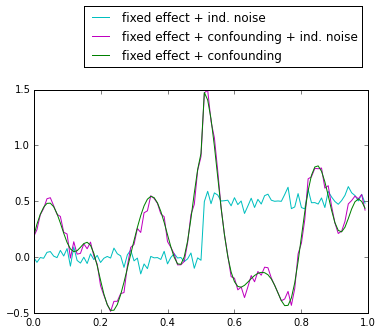

In [128]:
pl.plot(X[:,0], y_fn, 'c')
pl.plot(X[:,0], y_conf+y_fn, 'm')
pl.plot(X[:,0], y_conf + y_fixed, 'g')
pl.legend(['fixed effect + ind. noise',
           'fixed effect + confounding + ind. noise',
           'fixed effect + confounding'],
          bbox_to_anchor=(1.0, 1.4))

Next, we divide our data into training- and test sample.

In [129]:
training_sample = sp.zeros(n_sample, dtype='bool')
training_sample[sp.random.permutation(n_sample)[:sp.int_(.66*n_sample)]] = True
test_sample = ~training_sample
X_train = X[training_sample]
y_train = y_fn[training_sample]

We proceed by fitting the standard random forest to the training sample. We can do so using the mixed
RF module with the identity $\mathbf{I}$ as the covariance matrix (i.e. setting kernel=’iid’).

In [130]:
random_forest = LMF(kernel='iid')
random_forest.fit(X[training_sample],y_tot[training_sample])
response_rf = random_forest.predict(X[test_sample])

For fitting the mixed RF we need to pick the rows and colums of the covariance according to the training
sample indexes. For prediction we need to use the cross covariance between training and test samples.

In [131]:
kernel_train = kernel[sp.ix_(training_sample, training_sample)]
kernel_test = kernel[sp.ix_(test_sample, training_sample)]
lm_forest = LMF(kernel=kernel_train)
lm_forest.fit(X[training_sample],y_tot[training_sample])
response_lmf = lm_forest.predict(X[test_sample], k=kernel_test)

Finally, we plot the results of our prediction

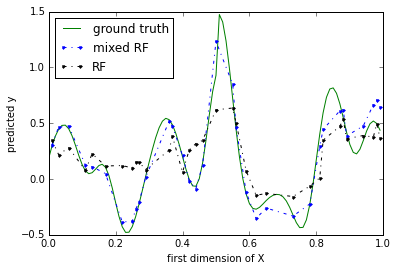

In [132]:
pl.plot(X[:,0:1], y_fixed + y_conf, 'g')
pl.plot(X[test_sample,0:1], response_lmf, '.b-.')
pl.plot(X[test_sample,0:1], response_rf, '.k-.')
pl.ylabel('predicted y')
pl.xlabel('first dimension of X')
pl.legend(['ground truth', 'mixed RF', 'RF'], loc=2)

### Example 2: Recovering interactions and evaluating feature importances
In the second toy example we predict held out simulated data when the phenotype is caused by an
interaction of features and the random effect. Now our feature vector is a sorted array of integers ranging
from 0 to $2^8−1=255$. We can easily convert this into a 8D feature vector using the binary encoding of
each integer, i.e 0 $\rightarrow$ (0, 0, 0, 0, 0, 0, 0, 0) , 1 $\rightarrow$ (0, 0, 0, 0, 0, 0, 0, 1), . . . and 255 $\rightarrow$ (1, 1, 1, 1, 1, 1, 1, 1).

In [133]:
sp.random.seed(42)
n_samples=2**8
x = sp.arange(n_samples).reshape(-1,1)
X = utils.convertToBinaryPredictor(x)

Our simulated fixed effect shall be an interaction of the fist and third feature dimension.

In [134]:
y_fixed = X[:,0:1] * X[:,2:3]

Finally, like in the previous example, we simulate confounding by adding a sample from a multivariate
gaussian with a squared quadratic covariance function.

In [135]:
kernel=utils.getQuadraticKernel(x, d=200) + sp.eye(n_samples)*1e-8
y_conf = y_fixed.copy()
y_conf += sp.random.multivariate_normal(sp.zeros(n_samples),kernel).reshape(-1,1)
y_conf += .1*sp.random.randn(n_samples,1)

In addition, we add a small amount of independent gaussian noise.
After splitting, we fit, both the mixed RF and the random forest on the training sample. Then test
sample is used obtain predictions.

In [136]:
(training, test) = utils.crossValidationScheme(2, n_samples)
lm_forest = LMF(kernel=kernel[sp.ix_(training, training)])
lm_forest.fit(X[training], y_conf[training])
response_tot = lm_forest.predict(X[test], kernel[sp.ix_(test,training)])
# make random forest prediction for comparison
random_forest = LMF(kernel='iid')
random_forest.fit(X[training], y_conf[training])
response_iid = random_forest.predict(X[test])

So far everthing is analog to the previous example. In addition the mixed RF allows us to predict the
fixed effect only. All we need to do is dropping the cross covariance from the parameters of the prediction
function, i.e

In [137]:
response_fixed = lm_forest.predict(X[test])

The results of all predictions an the ground truth can be observed in the figure below. To
visualize the whole binary predictor matrix $\mathbf{X}$ in a single dimension we just need to plot the prediction
against the original (decimal) feature vector $\mathbf{x}$.

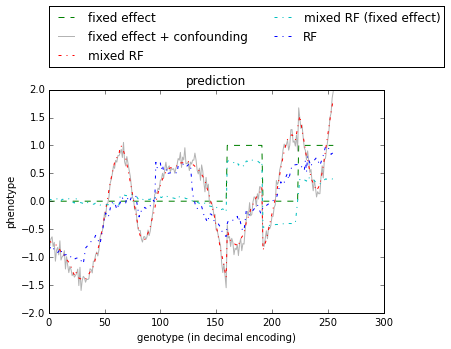

In [138]:
pl.plot(x, y_fixed, 'g--')
pl.plot(x, y_conf, '.7')
pl.plot(x[test], response_tot, 'r-.')
pl.plot(x[test], response_fixed, 'c-.')
pl.plot(x[test], response_iid, 'b-.')
pl.title('prediction')
pl.xlabel('genotype (in decimal encoding)')
pl.ylabel('phenotype')
pl.legend(['fixed effect', 'fixed effect + confounding', 
           'mixed RF', 'mixed RF (fixed effect)', 'RF'],
           bbox_to_anchor=(1.2, 1.4), ncol=2)

Finally, we evaluate the feature importances which are automatically computed while fitting the forests. These scores are plotted in the figure below.

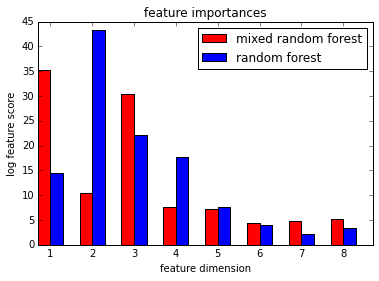

In [139]:
feature_scores_lmf = lm_forest.log_importance
feature_scores_rf = random_forest.log_importance

n_predictors = X.shape[1]
pl.bar(sp.arange(n_predictors), feature_scores_lmf, .3, color='r')
pl.bar(sp.arange(n_predictors)+.3, feature_scores_rf, .3, color='b')
pl.title('feature importances')
pl.xlabel('feature dimension')
pl.ylabel('log feature score')
pl.xticks(sp.arange(n_predictors)+.3, sp.arange(n_predictors)+1)
pl.legend(['mixed random forest', 'random forest'])